# Ford vs Ferrari (классификация изображений)

## Отчет о проделанной работе

**1. Выбор модели.**
Первым делом я попробовал применить одну из последних моделей линейки ImageNet наивно полагая что таким образом удастся повысить результат на submission. Была использована модель EfficientNet-L2 (480 MB) к которой в Kaggle я раздобыл веса (1.9 GB). Модель считала 6 часов и в итоге, к моему удивлению, дала результат в очень скромные 86%. После, я перешел на модель EfficientNet-B7 (66 MB) которая считала побыстрее и давала validation accuracy 95-96%. Тем не менее, работа модели всё равно занимала много времени и было решено попробывать модель EfficientNet-B3 (12 MB). Она считала гораздо быстрее и давала примерно такой же результат как и EfficientNet-B7. Важным моментом оказалось что использование легкой EfficientNet-B3 дало гибкость изменять параметры, задавать такие параметры с которыми EfficientNet-B7 не тянула и выдавала ошибки. Это оказалось ключевым моментом для повышения качества предсказаний. Стоит упомянуть что была попытка использовать модель не из линейки EfficientNet, а именно MaxVit-L. Однако, не получилось сразу наскоком ее запустить и я решил не терять времени разбираясь с ней. В общем не стоит гнаться за моделями с высокими рейтингами ибо они очень тяжелые. Работа приведенная ниже была выполнена с EfficientNet-B3.

**2. Batch size и Image resolution.**
Первым важным открытием было batch size не оказывает существенного влияния на validation accuracy. В тоже самое время, небольшой batch size позволил увеличить разрешение картинок (иначе модель не принимала тяжелые данные на вход) что в свою очередь сказалось на качестве результата сильным образом. В таблице ниже приведены результаты экспериментов: 
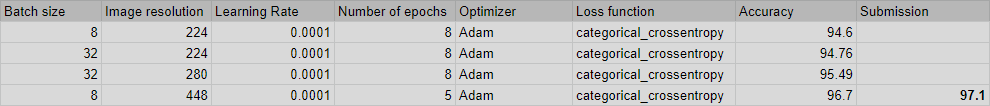
Вот так вот сразу удалось достигнуть весьма достойного результата в 97.1% на submission. 

**3. Optimizer.**
Не мудрствуя лукаво, я просто перебрал все доступные optimizers. Картинки были уменьшены до 71x71 для того чтобы быстрее считалось. В таблице ниже приведены результаты экспериментов: 
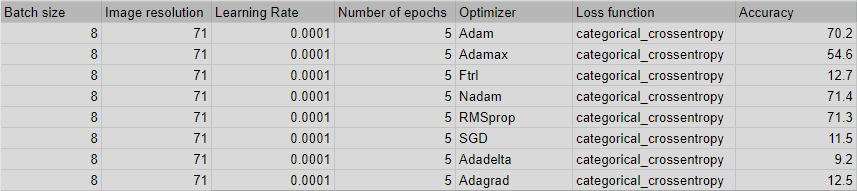
Optimizers Nadam и RMSprop дали результаты чуть повыше чем ранее используемый Adam.

**4. Loss function.**
Аналогично работе с optimizers, я перебрал несколько loss functions работающими с категориальной validation. В таблице ниже приведены результаты экспериментов: 
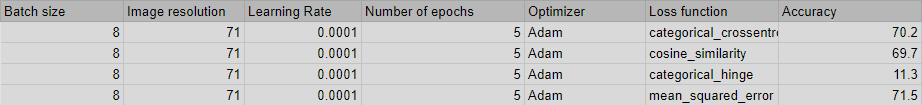
mean_squared_error дала результат получше чем categorical_crossentropy. Соответственно следующим логичным шагом было объеденить mean_squared_error c Nadam и RMSprop optimizers и посчитать на картинках высокого разрешения. В таблице ниже приведены результаты экспериментов: 
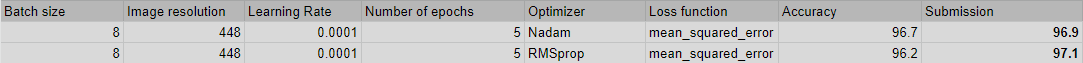
К сожалению на submission улучшения не было а был лишь повторен результат 97.1%

**5. Learning rate.**
Сперва я просто попробовал увеличить и уменьшить learning rate. В таблице ниже приведены результаты экспериментов: 
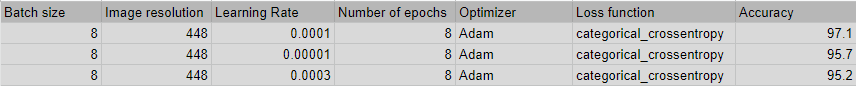
Улучшения это не дало. Следующим шагом было применение exponential decay для learning rate где я перебирал пару ключевых параметров на картинках низкого разрешения. Удалось добиться значительного улучшения однако когда я применил exponential decay для картинок высокого разрешения результат был плох. Причина сего сего казуса осталась для меня непонятной. Также стоит отметить что Nadam и RMSprop optimizers не могли быть использованы с exponential decay. В таблице ниже приведены результаты экспериментов: 
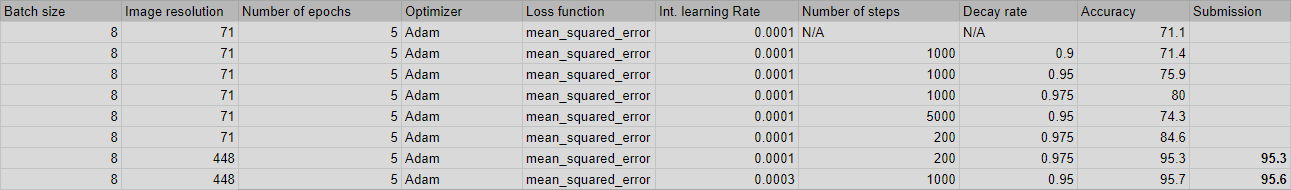
По-настоящему улучшения удалось достичь через управления learning rate через call back (см. ниже).

**6. Batch normalization и Flatten.**
Batch normalization и Flatten были по-очереди добавлены к model head. Как и в случае с learning rate, validation accuracy повысился для картинок низкого разрешения, однако прогресса не было для картинок высокого разрешения. В таблице ниже приведены результаты экспериментов: 
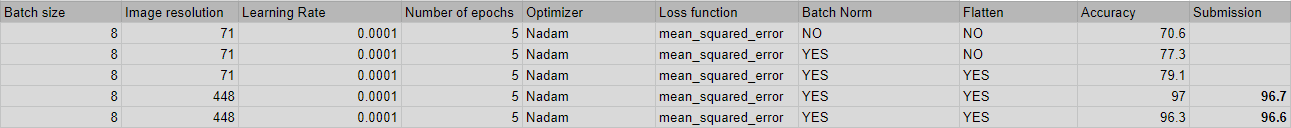
В конечной модели Batch normalization и Flatten были отключены.

**7. Callback.**
В работе были использованы следующие функции callback: 
-checkpoint (для сохранения лучшей итерации) 
-stopping (остановка обучения при отсутствии прогресса) 
-reduce_lr (управление learning rate) Последняя функция оказалась весьма действенной и дала улучшение на submission (97.38). В таблице ниже приведен результат эксперимента: 
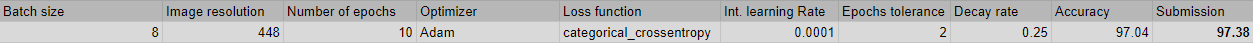

**8. Abumentation.**
Была попытка использования более продвинутой Albumentation (см. код ниже) однако результаты были низки. Должно быть я не разобрался с параметрами.

**9. Fine tuning.**
Fine tuning был сделан в 4 шага: сперва head, а потом подгружалась base model по 1/3. Соответственно learning rate не управлялся через callback а уменьшался вручную на каждом шаге: 1e-3, 1e-4, 3e-5, 1e-5. Validation accuracy улучшалось соответственно: 93.26, 94.93, 95.84, 96.14 и результат нв сабмишене всего 96.32%. Относительно низкий результат скорее всего получился из-за неоптимального learning rate.

**10. Assembling.**
Model assembling был осуществлен комбинацией двух моделей: Xception (95.71% на submission) и EfficientNet-B3 (97.24% на submission). Был сделан простенький перебор коэффициентов: Xception/EfficientNet-B3 = 0.33/0.67, 0.30/0.70 и 0.25/0.75 с результатами на submission 97.41, 97.43 и 97.41% соответственно. Таким образом лучший результат в 97.43 действительно оказался лучше чем каждая модель по отдельности. Assembling работает!

**Финальный аккорд**
В попытке прорваться в элиту состязания, разрешение картинок было повышено до 544x544, было использовано больше epochs и Assembling Xception с EfficientNet-B3. Финальный результат на submission следующий:

    Xception: 96.48%
    EfficientNet-B3: 97.38%
    Assembling: 97.438%

По-сути, без изменений.

Место: 34/285 

Код ниже является финальным без Cell outputs. Cell outputs по конкретным вариантам в предыдущих версиях: Fine tuning в Version 2, лучший результат включая Assembling (финальных аккорд) в Version 5.

In [ ]:
!nvidia-smi

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers.schedules import *
from tensorflow.keras.callbacks import *

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

**Работаем с Tensorflow v2**

In [ ]:
!pip freeze > requirements.txt

# Основные настройки

In [ ]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS               = 8  # эпох на обучение
BATCH_SIZE           = 8 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU

LR                   = 1e-4
#LR = ExponentialDecay(initial_learning_rate=3e-4, decay_steps=1000, decay_rate=0.95)
optimizer = Adam(LR)

VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 544 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/'
PATH = "../working/car/" # рабочая директория

In [ ]:
# Устаналиваем конкретное значение random seed для воспроизводимости
os.makedirs(PATH,exist_ok=False)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# EDA / Анализ данных

In [ ]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

In [ ]:
train_df.info()

In [ ]:
train_df.Category.value_counts()
# распределение классов достаточно равномерное - это хорошо

In [ ]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile("../input/"+data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

In [ ]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжимать.

In [ ]:
image = PIL.Image.open(PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

# Подготовка данных

### Аугментация данных

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=False)

test_datagen = ImageDataGenerator(rescale=1. / 255)


In [ ]:
# Albumentation:
import albumentations as A

def augment(image):
  image = image.astype(np.uint8)
  aug = A.Compose([
      A.Cutout(p=0.5, num_holes=1, max_h_size=150, max_w_size=200),
      A.Cutout(p=0.5, num_holes=1, max_h_size=100, max_w_size=150), #второй раз
      A.Cutout(p=0.5, num_holes=1, max_h_size=80, max_w_size=100), #третий раз
      A.HorizontalFlip(p=0.3),
      A.ShiftScaleRotate(p=0.5),
      A.HueSaturationValue(p=1),
  ])
  return aug(image=image)['image']

#train_datagen = ImageDataGenerator(
#    preprocessing_function=augment
#)

#test_datagen = ImageDataGenerator(
#    preprocessing_function=augment
#)


### Генерация данных

In [ ]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)


# Построение и обучение моделей

### Xception:

In [ ]:
base_model_Xception = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

In [ ]:
#Head setup:

x = base_model_Xception.output
#x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
#x = Flatten()(x)
# and a logistic layer - we have 10 classes
predictions_Xception = Dense(CLASS_NUM, activation='softmax')(x)

# this is the Xception model to train
model_Xception = Model(inputs=base_model_Xception.input, outputs=predictions_Xception)
model_Xception.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
# Best model saving:
checkpoint_Xception = ModelCheckpoint('best_model_Xception.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')

In [ ]:
callbacks_list_Xception = [checkpoint_Xception]

In [ ]:
#Training:
history = model_Xception.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list_Xception
)

In [ ]:
#Save results and load the best epoch (best_model):
model_Xception.save('../working/model_last.hdf5')
model_Xception.load_weights('best_model_Xception.hdf5')

In [ ]:
# Scoring:
scores = model_Xception.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

### EfficientNetB3

In [ ]:
!pip install -q efficientnet
import efficientnet.tfkeras as efn

In [ ]:
base_model = efn.EfficientNetB3(weights='imagenet', include_top=False, input_shape=input_shape)

In [ ]:
#base_model.summary()

In [ ]:
# Head setup:

x = base_model.output
#x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
#x = Flatten()(x)
# and a logistic layer - we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
#model.summary()

In [ ]:
# Best model saving:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')

In [ ]:
# Stop learning if no improvement after 4 epochs:
stopping = EarlyStopping(monitor='val_loss', patience=4)

In [ ]:
# Reduce learning rate if no improvement after 2 epochs:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25,
                              patience=2, min_lr=0.00001)

In [ ]:
# Callbacks:
callbacks_list = [checkpoint, reduce_lr, stopping]

In [ ]:
#Training:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)


In [ ]:
#Save results and load the best epoch (best_model):
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
# Scoring:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
# Training visualization:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

# Fine tuning

In [ ]:
!pip install -q efficientnet
import efficientnet.tfkeras as efn

In [ ]:
base_model = efn.EfficientNetB3(weights='imagenet', include_top=False, input_shape=input_shape)

In [ ]:
#Head setup with the new learning rate:

x = base_model.output
#x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
#x = Flatten()(x)
# and a logistic layer - we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
#Best model saving:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')

In [ ]:
#Stop training if no improvement after 3 epochs:
stopping = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
# Callbacks:
callbacks_list = [checkpoint, stopping]

**1st step (training with head only)**

In [ ]:
#New learning rate:
LR = 1e-3
optimizer = Adam(LR)

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
#Freeze the base_model:
base_model.trainable = False

In [ ]:
print("Number of layers in the model: ", len(model.layers))

In [ ]:
print("Number of trainable layers in the model: ",len(model.trainable_variables))

In [ ]:
#Training:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

In [ ]:
#Save results and load the best epoch (best_model):
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
#Scoring:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
#Training visualization:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

**2nd step (training with 1/3 of base_model available)**

In [ ]:
#New learning rate:
LR = 1e-4
optimizer = Adam(LR)

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
#Enable 1/3 of base_model for training:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//3*2

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
print("Number of layers in the model: ", len(model.layers))

In [ ]:
print("Number of trainable layers in the model: ",len(model.trainable_variables))

In [ ]:
# Check the trainable status of the individual layers
#for layer in model.layers:
#    print(layer, layer.trainable)

In [ ]:
#Training:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

In [ ]:
#Save results and load the best epoch (best_model):
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
#Scoring:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
#Training visualization:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

**3rd step (training with 2/3 of base_model available)**

In [ ]:
#New learning rate:
LR = 3e-5
optimizer = Adam(LR)

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
#Enable 2/3 of base_model for training:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//3

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
print("Number of layers in the model: ", len(model.layers))

In [ ]:
print("Number of trainable layers in the model: ",len(model.trainable_variables))

In [ ]:
#Training:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

In [ ]:
#Save results and load the best epoch (best_model):
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
#Scoring:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
#Training visualization:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

**4th step (training with base_model fully available)**

In [ ]:
#New learning rate:
LR = 1e-5
optimizer = Adam(LR)

In [ ]:
#Head setup with the new learning rate:

x = base_model.output
#x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
#x = Flatten()(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
#Enable base_model for training:
base_model.trainable = True

In [ ]:
print("Number of layers in the model: ", len(model.layers))

In [ ]:
print("Number of trainable layers in the model: ",len(model.trainable_variables))

In [ ]:
#Training:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

In [ ]:
#Save results and load the best epoch (best_model):
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
#Scoring:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
#Training visualization:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

# Предсказание на тестовых данных

In [ ]:
test_sub_generator.samples

In [ ]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission_B3-2.csv', index=False)
print('Save submit')

In [ ]:
submission.head()

# Assembling models

Let's combine couple of models to check how assembling works

In [ ]:
test_sub_generator.reset()
predictions = 0.75*model.predict(test_sub_generator) \
    + 0.25*model_Xception.predict(test_sub_generator)
predictions = predictions.argmax(axis=1)
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission_assemb-3.csv', index=False)
print('Save submit')

In [ ]:
submission.head()

In [ ]:
# Clean PATH
import shutil
shutil.rmtree(PATH)